#### <b>Topic: Emotion Detection Using Convolutional Neural Networks</b>

This Notebook was co-authored by Samuel Oladejo (2441199) and Phola Bavuma(1848739 )

##### Overview: 

We identified the following emotions: happiness, sadness, neutral, anger, disgust, and fear. Given the increasing levels of sadness in the midst of the covid-19, our long-term goal is to expand this project as a tool to be used in a voice-based assistant on a suicide prevention hotline.

##### Aim: 

Explore the use Convolution Neural Networks (CNN) for analyzing conversations to detect the emotion and gender of a speaker.


##### Objectives:  

1. Download, Prepare and Pre-process audio data. 
2. Extract necessary features from the audio data. 
3. Build and Train our model based on the acoustic features of the audio data recording
4. Get Inference about our model based on the structural features of the audio data.


##### Definitions:
- Audio Processing: is a subfield of signal processing that is concerned with the electronic manipulation of audio signals.
  
- Mel-frequency cepstral coefficients  (MFCC):  are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum").

- Spectrogram: is the visual representation of the spectrum of frequencies of the signal as it changes with time. 

- Convolutional Neural Network (CNN): is a type of artificial neural network used in image and audio recognition and processing that is specifically designed to process signal data.

- Learning Rate: is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function.
  
- Sampling: sampling is the reduction of a continuous signal into a series of discrete values
  
- Sampling Frequency:  sampling frequency or rate is the number of samples taken over some fixed amount of time. A high sampling frequency results in less information loss but higher computational expense, and low sampling frequencies have higher information loss but are fast and cheap to compute.



##### Data:

In this Notebook, we made use of the following dataset:


<b>1. The Ryerson Audio-Visual Database of Emotional Speech and Song Dataset (Ravdees):</b> This dataset consists of 1440 files audio files which  was recorded with 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. 

1440 files = (24 actors x 60 trails per actor).

8 emotions = (neutral, calm, happy, sad, angry, fearful, disgust, surprised).

link: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

<b>2. Surrey Audio-Visual Expressed Emotion (SAVEE):</b> This dataset was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. A neutral category is also added to provide recordings of 7 emotion categories. The text material consisted of 15 TIMIT sentences per emotion: 3 common, 2 emotion-specific and 10 generic sentences that were different for each emotion and phonetically-balanced. The 3 common and 2 × 6 = 12 emotion-specific sentences were recorded as neutral to give 30 neutral sentences. This resulted in a total of 120 utterances per speaker

480 files = (4 male actors).

8 emotions = (neutral, calm, happy, sad, angry, fearful, disgust, surprised).

link: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee

<b>3. Crowd Sourced Emotional Multimodal Actors Dataset (CREMA-D):</b> This dataset consists of 7442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences.

7442 files = (91 actors).

6 emotions = (Anger, Disgust, Fear, Happy, Neutral, Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

link: https://www.kaggle.com/datasets/ejlok1/cremad

<b>4. Toronto emotional speech set (TESS): </b> This dataset consists of a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years). There are 2800 data points (audio files) in total. The dataset is organised such that each of the two female actor and their emotions are contain within its own folder. And within that, all 200 target words audio file can be found. The format of the audio file is a WAV format 

2800 files = (2 female actors).

8 emotions = (anger, disgust, fear, happiness, pleasant surprise, sadness, neutral).

link: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess

#### <b>1. Setup</b>
*******

Running this Notebook on Google Colab?
* If yes, start from 1.1: Mounting Google Drive
* If No, Skip to 1.3: Install Necessary Packages

###### 1.1. Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### 1.2. Change Working Directory

In [ ]:
cd /content/drive/MyDrive/speech-emotion-recognition

/content/drive/MyDrive/speech-emotion-recognition


##### 1.3. Install Necessary Packages

In [ ]:
!pip install -r req.txt


##### 1.4. Importing Packages

In [2]:
import numpy as np
import pandas as pd
import librosa as lb
import seaborn as sns
import soundfile as sf
import os, glob, pickle, time
import librosa.display as ldisp
import matplotlib.pyplot as plt


from datetime import datetime
from tqdm.notebook import tqdm
from pydub import AudioSegment as AS
from IPython.display import Audio as aud


# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')
start = time.time()
end = time.time()

plt.style.use('bmh')
sns.set_style('whitegrid')
FIGSIZE = (15,10)
%matplotlib inline

print("All Packages Loaded...")

All Packages Loaded...


#### 2. <b>Loading Data</b>
*******

##### 2.1. Selecting Dataset

In [3]:
#choose a dataset to load
def get_dataset(tess, ravdess, savee, crema):
    dataset = {'tess': tess, 'ravdess':ravdess, 'savee':savee , 'crema':crema}
    print(dataset)

    return dataset

##### 2.2. Selecting Emotions

In [4]:
emotions={'01':'neutral', '02':'calm', '03':'happy', '04':'sad', '05':'angry', '06':'fear', '07':'disgust', '08':'surprise', '09': 'unknown'}

all_emotions = ['sad','angry','happy','disgust','surprise','neutral','calm','fear']

##### 2.3. Loading Data

In [5]:
def load_data(tess, ravdess, savee, crema):

    path = os.getcwd()

    emotion, gender, intensity, audio_path=([], [], [], [])

    dataset = get_dataset(tess, ravdess, savee, crema)
    tess_path = (path + '/tess/*AF_*/*.wav')
    ravdess_path = (path + '/ravdess/Actor_*/*.wav')
    savee_path = (path + '/savee/*.wav')
    crema_path = (path + '/crema/10*.wav')


    if dataset['tess']:
         for x in glob.glob(tess_path):
            file = os.path.basename(x)
            cls = file.split('.')[0]
            cls = cls.split('_')[2]
          
            if(cls == 'ps'):
                emotion.append('surprise')
            else:
              emotion.append(cls)

            gender.append('female')
            intensity.append('unknown')
            audio_path.append(x)
          

    
    if dataset['ravdess']:
        for x in glob.glob(ravdess_path):
            file = os.path.basename(x)
            cls = file.split('.')[0]
            cls = cls.split('-')
            emot = emotions[cls[2]]
            emotion.append(int(cls[2]))
            if emot in emotion not in all_emotions:
                continue

            id = int(cls[6])
            if id%2==0:
              gender.append('female')
            else:
              gender.append('male')

            intensity.append(int(cls[3]))
            for y in emotion:
              if y =='1':
                intensity.append('medium')
              elif y=='2':
                intensity.append('high')

            audio_path.append(x)

    if dataset['savee']:
        for x in glob.glob(savee_path):
          file = os.path.basename(x)
          cls = file.split('.')[0]
          cls = cls.split('_')[1]  

          if cls=='n*':
              emotion.append('neutral')
          elif cls=='h*':
              emotion.append('happy')
          elif cls=='sa*':
              emotion.append('sad')
          elif cls=='a*':
              emotion.append('angry')
          elif cls=='f*':
              emotion.append('fear')
          elif cls=='d*':
              emotion.append('disgust')
          else:
              emotion.append('surprise')

          gender.append('male')
          intensity.append('unknown')
          audio_path.append(x)

    if dataset['crema']:
        for x in glob.glob(crema_path):
            file = os.path.basename(x)
            cls = file.split('.')[0]
            cls = cls.split('_')  

            if cls[2] == 'NEU':
                emotion.append('neutral')
            elif cls[2] == 'HAP':
                emotion.append('happy') 
            elif cls[2] == 'SAD':
                emotion.append('sad')
            elif cls[2] == 'ANG':
                emotion.append('angry')
            elif cls[2] == 'FEA':
                emotion.append('fear')
            elif cls[2] == 'DIS':
                emotion.append('disgust')
            elif cls[2] == 'FEA':
                emotion.append('fear')
            else:
                emotion.append('unknown')

            id = int(cls[0])
            if id%2==0:
              gender.append('female')
            else:
              gender.append('male')

            if cls[3]=='HI':
                intensity.append('high')
            elif cls[3]=='LO':
                intensity.append('low')
            elif cls[3]=='MD':
                intensity.append('med')
            elif cls[3]=='XX':
                intensity.append('unknown')

            audio_path.append(x)

    emotion_data = pd.DataFrame(emotion, columns = ['emotions'])
    path_data = pd.DataFrame(audio_path, columns = ['audio path'])
    gender_data = pd.DataFrame(gender, columns = ['gender'])
    intensity_data = pd.DataFrame(intensity, columns = ['intensity'])

    data = pd.concat([emotion_data, path_data, gender_data, intensity_data], axis=1)

    data.emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace = True)
    data.intensity.replace({1:'med', 2: 'high', 3: 'low', 4:'unknown'}, inplace = True)

    return data


In [6]:
data = load_data(tess=True, ravdess=True, savee=True, crema=True).dropna()

data

{'tess': True, 'ravdess': True, 'savee': True, 'crema': True}


,emotions,audio path,gender,intensity
0,neutral,/home/vmuser/Documents/files/ml/tess/OAF_neutr...,female,unknown
1,neutral,/home/vmuser/Documents/files/ml/tess/OAF_neutr...,female,unknown
2,neutral,/home/vmuser/Documents/files/ml/tess/OAF_neutr...,female,unknown
3,neutral,/home/vmuser/Documents/files/ml/tess/OAF_neutr...,female,unknown
4,neutral,/home/vmuser/Documents/files/ml/tess/OAF_neutr...,female,unknown
...,...,...,...,...
10908,fear,/home/vmuser/Documents/files/ml/crema/1044_WSI...,female,unknown
10909,happy,/home/vmuser/Documents/files/ml/crema/1052_DFA...,female,unknown
10910,happy,/home/vmuser/Documents/files/ml/crema/1023_TAI...,male,unknown
10911,happy,/home/vmuser/Documents/files/ml/crema/1036_ITH...,female,unknown


#### 3. <b>Data Exploration and Visualization</b>

##### 3.1. <b>Data Exploration</b>

###### 3.1.1. Data Information

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913 entries, 0 to 10912
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   emotions    10913 non-null  object
 1   audio path  10913 non-null  object
 2   gender      10913 non-null  object
 3   intensity   10913 non-null  object
dtypes: object(4)
memory usage: 426.3+ KB


###### 3.1.2. Data Description

In [8]:
#data info
data.describe().T

,count,unique,top,freq
emotions,10913,8,sad,1662
audio path,10913,10913,/home/vmuser/Documents/files/ml/tess/OAF_neutr...,1
gender,10913,2,female,6577
intensity,10913,4,unknown,9356


###### 3.1.3. Gender Distribution

,emotions
gender,
female,6577
male,4336


<Figure size 1080x720 with 0 Axes>

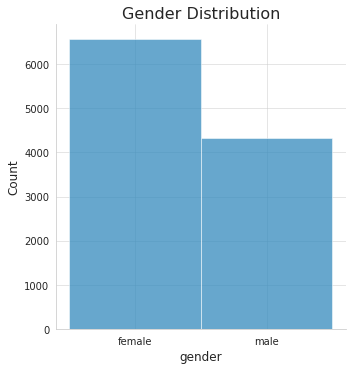

In [9]:
plt.figure(figsize=FIGSIZE)
ax = sns.displot(data, x='gender')
plt.title('Gender Distribution', fontsize=16)
plt.savefig('Gender Distribution.png', dpi=600)   

data[['gender', 'emotions']].groupby(['gender']).count()

###### 3.1.4. Emotions Distribution

,gender
emotions,
angry,1641
calm,192
disgust,1657
fear,1660
happy,1638
neutral,1391
sad,1662
surprise,1072


<Figure size 1080x720 with 0 Axes>

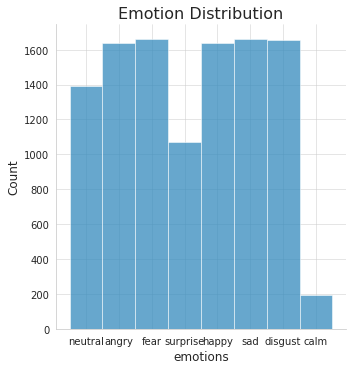

In [10]:
plt.figure(figsize=FIGSIZE)
ax = sns.displot(data, x='emotions')
plt.title('Emotion Distribution', fontsize=16)
plt.savefig('Emotion Distribution.png', dpi=600)

data[['gender', 'emotions']].groupby(['emotions']).count()

###### 3.1.5. Intensity Distribution

,emotions
intensity,
high,551
low,455
med,551
unknown,9356


<Figure size 1080x720 with 0 Axes>

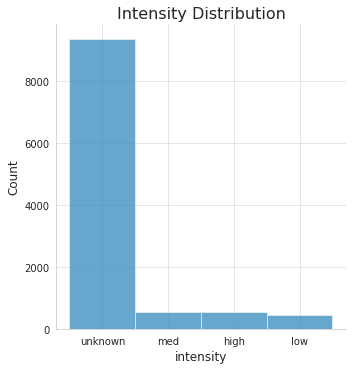

In [11]:
plt.figure(figsize=FIGSIZE)
ax = sns.displot(data, x='intensity')
plt.title('Intensity Distribution', fontsize=16)
plt.savefig('Intensity Distribution.png', dpi=600)


data[['emotions', 'intensity']].groupby(['intensity']).count()

Due to the disparity between the number of the known intensity data and the unknown ones, we concluded that it will be suitable to train our model with just the emotions labels and rather drop the intensity column to avoid discrepancies during Model Training.

###### 3.1.6. Unique Columns

In [12]:
#Checking Unique Emotions
data['emotions'].unique()

array(['neutral', 'angry', 'fear', 'surprise', 'happy', 'sad', 'disgust',
       'calm'], dtype=object)

###### 3.1.7. Gendered Emotions

In [13]:
male =  pd.DataFrame(data[data['gender'] == 'male']['emotions'])
female = pd.DataFrame(data[data['gender'] == 'female']['emotions'])

male.replace({ 'emotions': {'neutral': 'neutral_male', 'calm': 'calm_male','happy': 'happy_male', 'sad': 'sad_male', 'angry': 'angry_male','fear': 'fearful_male', 'disgust': 'disgusted_male', 'surprise': 'surprised_male'}}, inplace = True)
female.replace({ 'emotions': {'neutral': 'neutral_female', 'calm': 'calm_female','happy': 'happy_female', 'sad': 'sad_female', 'angry': 'angry_female','fear': 'fearful_female', 'disgust': 'disgusted_female', 'surprise': 'surprised_female'}}, inplace = True)

data['gendered_emotions'] = pd.concat([male, female], axis = 0)

3.1.7.1. Emotion Distribution of Each Gender

,gender
gendered_emotions,
angry_female,947
angry_male,694
calm_female,67
calm_male,125
disgusted_female,1011
disgusted_male,646
fearful_female,1007
fearful_male,653
happy_female,997


<Figure size 1080x720 with 0 Axes>

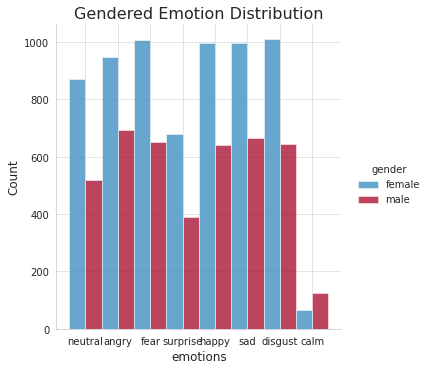

In [15]:
plt.figure(figsize=FIGSIZE)

#sns.set(rc={'figure.figsize': (15,10)})
ax = sns.displot(data, x="emotions", hue="gender", multiple="dodge")
plt.title('Gendered Emotion Distribution', fontsize=16)
plt.savefig('Gendered Emotion Distribution.png', dpi=600)

data[['gender', 'gendered_emotions']].groupby(['gendered_emotions']).count()

In [16]:
data

,emotions,audio path,gender,intensity,gendered_emotions
0,neutral,/home/vmuser/Documents/files/ml/tess/OAF_neutr...,female,unknown,neutral_female
1,neutral,/home/vmuser/Documents/files/ml/tess/OAF_neutr...,female,unknown,neutral_female
2,neutral,/home/vmuser/Documents/files/ml/tess/OAF_neutr...,female,unknown,neutral_female
3,neutral,/home/vmuser/Documents/files/ml/tess/OAF_neutr...,female,unknown,neutral_female
4,neutral,/home/vmuser/Documents/files/ml/tess/OAF_neutr...,female,unknown,neutral_female
...,...,...,...,...,...
10908,fear,/home/vmuser/Documents/files/ml/crema/1044_WSI...,female,unknown,fearful_female
10909,happy,/home/vmuser/Documents/files/ml/crema/1052_DFA...,female,unknown,happy_female
10910,happy,/home/vmuser/Documents/files/ml/crema/1023_TAI...,male,unknown,happy_male
10911,happy,/home/vmuser/Documents/files/ml/crema/1036_ITH...,female,unknown,happy_female


##### 3.2. <b>Data Visualization</b>

###### 3.2.1. Importing Visualization Packages

In [17]:
import wave

from python_speech_features import logfbank, mfcc

###### 3.2.2. Defining Visualization Functions

In [34]:
plt.figure(figsize=FIGSIZE)

## plotting functions
def plot_signals(signals):
    fig,axes = plt.subplots(nrows = 2,ncols=4,sharex=False,sharey=True,figsize=(20,5))
    fig.suptitle('Time Series',size=16)
    i=0
    for x in range(2):
        for y in range(4):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1
    plt.savefig('Time Series.png', dpi=600)


def plot_fft(fft):
    fig,axes = plt.subplots(nrows = 2,ncols=4,sharex=False,sharey=True,figsize=(20,5))
    fig.suptitle('Fourier Transforms',size=16)
    i =0
    for x in range(2):
        for y in range(4):
            data = list(fft.values())[i]
            Y,freq = data[0],data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq,Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+= 1
    plt.savefig('Fast Fourier Transforms.png', dpi=600)

def plot_fbank(fbank):
    fig,axes = plt.subplots(nrows = 2,ncols=4,sharex=False,sharey=True,figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients',size=16)
    i =0
    for x in range(2):
        for y in range(4):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i], cmap = 'hot',interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+= 1
    plt.savefig('Filter Bank Coefficients.png', dpi=600)

def plot_mfccs(mfccs):
    fig,axes = plt.subplots(nrows=2,ncols=4,sharex=False,sharey = True,figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients',size = 16)
    i =0
    for x in range(2):
        for y in range(4):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],cmap = 'hot',interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+= 1
    plt.savefig('Mel Frequency Cepstrum Coefficients.png', dpi=600)

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n,d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y,freq)

def sound_wave(data, sig, sr):
    ind = np.random.randint(0,len(data))
    emotion = data['emotions'][ind]
    plt.title(f'Sound wave of- {emotion}')
    lb.display.waveshow(sig[ind], sr)
    plt.show()
    plt.savefig('Sound Wave.png', dpi=600)

def spect(DB):
    lb.display.specshow(DB, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f db')
    plt.savefig('Audio Spectrogram.png', dpi=600)



<Figure size 1080x720 with 0 Axes>

###### 3.2.3. Visualizing Data

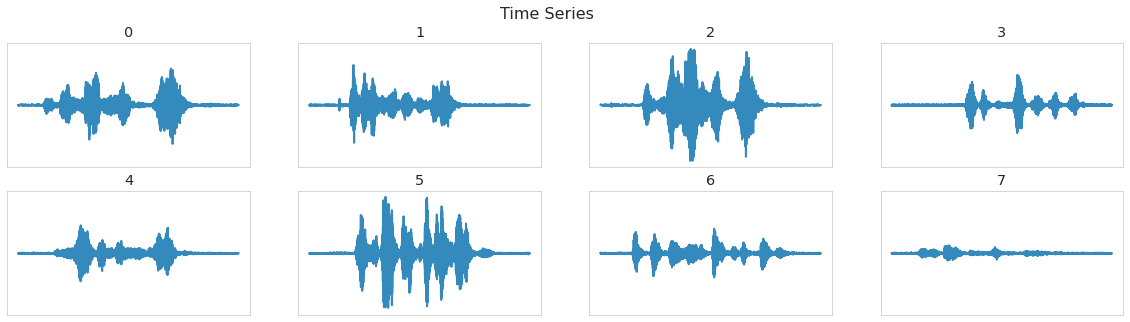

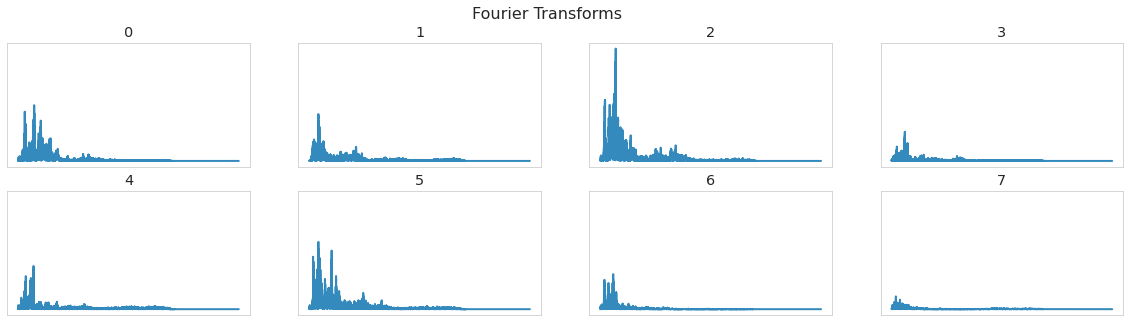

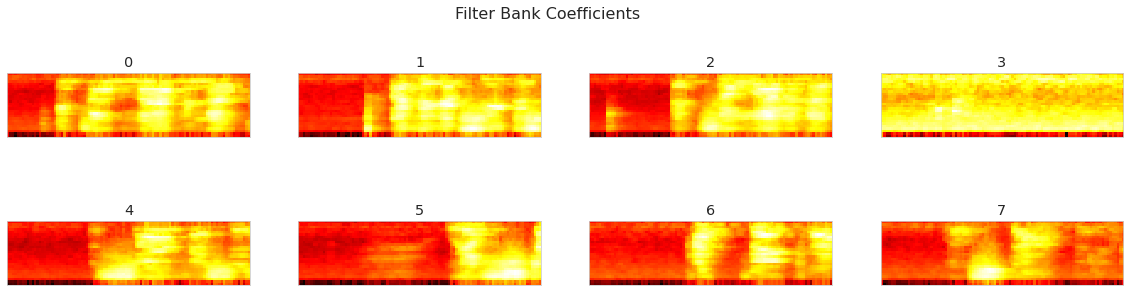

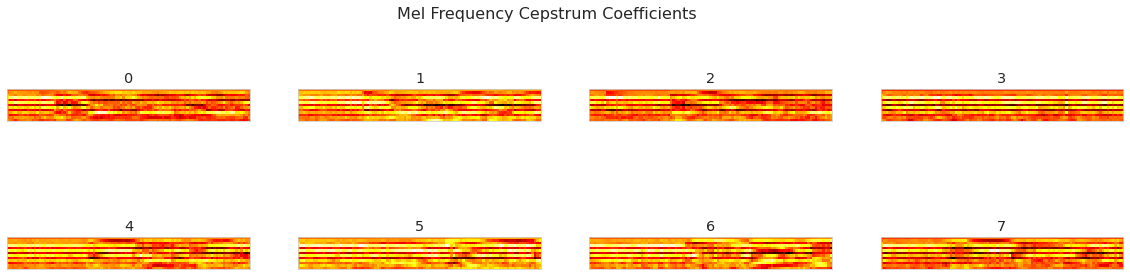

In [19]:
temp = data #maybe 
t =temp.drop_duplicates(subset='emotions', keep="last")
t = t.reset_index(drop=True)


sig ={}
fft = {}
fbank = {}
mfccs = {}
for c in range(len(t)):
    audio, sr = lb.load(t['audio path'][c])
    sig[c] = audio
    fft[c] = calc_fft(audio,sr)
    bank = logfbank(audio[:sr],sr,nfilt=26,nfft=1103).T
    fbank[c] = bank
    mel = mfcc(audio[:sr],sr,numcep=13,nfilt=26,nfft=1103).T
    mfccs[c] = mel

D = np.abs(lb.stft(audio))
DB = lb.amplitude_to_db(D, ref=np.max)

plot_signals(sig)

plot_fft(fft)

plot_fbank(fbank)

plot_mfccs(mfccs)

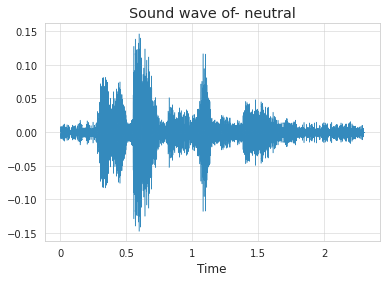

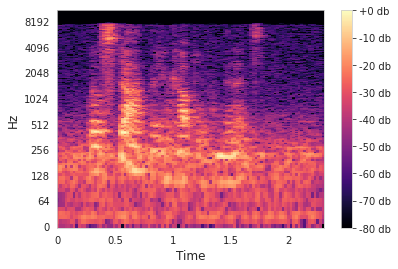

In [35]:
sound_wave(t, sig, sr)
spect(DB)

#### 4. <b>Data Pre-processing</b>

##### 4.2. <b>Data Augumentation</b>

In [36]:
#data augmentaion : to get our model to generalize.

#1) Adding white noise
def add_noise(data,noise_factor):
  noise = np.random.normal(0,data.std(),data.size)
  new_sound = data + noise*noise_factor
  return new_sound

#2) time stretch
def time_stretch(data,stretch_rate):
  return lb.effects.time_stretch(data, stretch_rate)

#3) pitch scaling
def pitch_scaling(data,sample_rate,pitch_factor):
  return lb.effects.pitch_shift(data,sample_rate,pitch_factor)

#4)polarity inversion
def invert_polarity(data):
  return data*-1

#5)random gain
def random_gain(data,min_gain,max_gain):
  gain = random.uniform(min_gain,max_gain)
  return gain*data

##### 4.3. <b>Feature Extraction</b>

###### 4.3.1 Importing Packages

In [37]:
import random

###### 4.3.2 Defining Feature Extraction Functions

In [38]:
def wav_info(file):
    #audio time series and sample rate
    sig, sr = lb.load(file, sr=22050*2, duration = 2.5, mono = True, offset=0.5)
    
    return sig, sr

#Extracting mfcc, mel and chroma from soundfile
def feature_extraction(file, mfcc, chroma, mel):
    #audio time series and sample rate
    sig, sr = wav_info(file)

    #converting sample rate to an arrat
    sr = np.array(sr)

    #data augumentation
    noise_sig = add_noise(sig,0.2)
    pitch_sig = pitch_scaling(noise_sig,sr,0.2)
    time_sig = time_stretch(pitch_sig, 0.5)
    newsig = random_gain(time_sig,0.1,0.5)

    #feature extraction
    if chroma:
        stft = np.abs(lb.stft(newsig))

    result = np.array([])

    if mel:
        mel = np.mean(lb.feature.melspectrogram(newsig, sr=sr).T, axis = 0)
        result = np.hstack((result,mel))

    if  mfcc:
        mfccs = np.mean(lb.feature.mfcc(y=newsig, sr = sr, n_mfcc = 40).T, axis=0)
        result = np.hstack((result,mfccs))

    if chroma:
        chroma = np.mean(lb.feature.chroma_stft(S=stft, sr=sr).T, axis = 0)
        result = np.hstack((result,chroma))
              
    return result

###### 4.3.3 Extracting Features

In [39]:
samp = data.sample(frac = 0.32)


Note: This Cell takes a while to load

In [ ]:
set_index=0

audio_info = pd.DataFrame(columns=['audio'])
mel_feat = pd.DataFrame(columns=['feature'])
chroma_feat = pd.DataFrame(columns=['feature'])
mfcc_feat = pd.DataFrame(columns=['feature'])
data_features = pd.DataFrame(columns=['feature'])

for i in range(len(samp)):
    files = list(samp['audio path'])[i]
    for x in glob.glob(files):
        sig, sr = wav_info(x)
        
        mel_features = feature_extraction(x, mfcc=False, chroma=False, mel=True)
        chroma_features = feature_extraction(x, mfcc=False, chroma=True, mel=False)
        mfcc_features = feature_extraction(x, mfcc=True, chroma=False, mel=False)
        all_features = feature_extraction(x, mfcc=True, chroma=True, mel=True)
        
        audio_info.loc[set_index] = [sig]
        mel_feat.loc[set_index] = [mel_features]
        chroma_feat.loc[set_index] = [chroma_features]
        mfcc_feat.loc[set_index] = [mfcc_features]
        data_features.loc[set_index] = [all_features]

        set_index = set_index+1

mel_feat_df = pd.DataFrame(mel_feat['feature'].values.tolist())
chroma_feat_df = pd.DataFrame(chroma_feat['feature'].values.tolist())
mfcc_feat_df = pd.DataFrame(mfcc_feat['feature'].values.tolist())
data_features_df = pd.DataFrame(data_features['feature'].values.tolist())

audio_info.to_csv('audio_info.csv', index = False)
mel_feat_df.to_csv('mel_feat_df.csv', index = False)
chroma_feat_df.to_csv('chroma_feat_df.csv', index = False)
mfcc_feat_df.to_csv('mfcc_feat_df.csv', index = False)
data_features_df.to_csv('data_features_df.csv', index = False)

###### 4.3.4. Load Features Dataset

In [45]:
def create_df(data, path, gen):
    if gen:
      new_emot = samp['gendered_emotions'].reset_index()
    else:
      new_emot = samp['emotions'].reset_index()

    new_df = pd.read_csv('./' + path + '_df.csv')
    new_data = pd.concat([new_emot, new_df], axis = 1)
    new_data.drop('index', inplace=True, axis=1)
    new_data = new_data.reindex(np.random.permutation(new_data.index))

    if gen:
      new_data.to_csv(path + '_gen.csv', index = False)
    else:
      new_data.to_csv(path +'.csv', index = False)
    
    return new_data

In [47]:
def dt(samp, gen=False):
    mel_path = 'mel_feat'
    chroma_path= 'chroma_feat'
    mfcc_path= 'mfcc_feat'

    mel_data = create_df(samp, mel_path, gen)
    chroma_data = create_df(samp, chroma_path, gen)
    mfcc_data= create_df(samp, mfcc_path, gen)

    return mel_data, chroma_data, mfcc_data


In [54]:
mel_data, chroma_data, mfcc_data = dt(samp)
df = pd.read_csv('audio_data.csv')

In [56]:
df

,emotions,0,1,2,3,4,5,6,7,8,...,170,171,172,173,174,175,176,177,178,179
0,angry,-355.926575,113.047867,-19.662279,28.739185,-14.963324,7.650365,-4.908675,4.803891,-10.209544,...,0.463388,0.450711,0.407664,0.499458,0.525714,0.449517,0.407220,0.434595,0.541392,0.641723
1,angry,-431.657684,96.823288,-26.441553,22.136810,-19.587282,9.573848,-2.715644,-19.170429,-2.298537,...,0.629640,0.393215,0.368867,0.387324,0.342959,0.337507,0.406749,0.406963,0.386757,0.423958
2,surprise,-407.545349,110.389816,-37.368092,29.455372,-29.530512,3.738931,-6.036850,-5.434225,-0.357959,...,0.441496,0.405431,0.429981,0.407068,0.333318,0.394362,0.461423,0.487643,0.499275,0.464483
3,disgust,-491.958252,123.533012,19.035109,38.612892,-13.654468,8.572597,-0.175319,-9.859588,8.987345,...,0.459475,0.495718,0.546845,0.536380,0.527686,0.546831,0.511518,0.474220,0.466247,0.497212
4,happy,-412.405518,70.135918,-45.850506,43.946220,-3.915982,4.987489,-12.847577,-7.292311,-3.163887,...,0.628456,0.548277,0.534832,0.522270,0.520007,0.485884,0.431376,0.448371,0.448190,0.497704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459,surprise,-431.694244,91.665359,-32.077656,24.222116,-42.606400,-8.181530,-7.642555,-5.344500,-0.548608,...,0.481015,0.444825,0.487359,0.524109,0.466243,0.441837,0.487239,0.505916,0.454339,0.429548
3460,calm,-566.172668,61.267498,-33.189857,6.833303,-6.540302,-1.150639,-20.196327,-6.988005,-20.355450,...,0.391467,0.452739,0.616793,0.649843,0.495830,0.438536,0.520420,0.604747,0.515812,0.484828
3461,happy,-485.612396,122.361038,-5.491082,32.066536,-22.536140,21.950790,-7.939838,-15.281415,7.822705,...,0.463970,0.441580,0.435116,0.503007,0.586889,0.583848,0.522413,0.491241,0.455403,0.420771
3462,disgust,-500.023743,111.474426,-11.774171,33.533855,-2.147152,25.020075,-3.290683,-12.279593,7.935911,...,0.535476,0.532808,0.562689,0.568170,0.574267,0.525436,0.510129,0.566966,0.636831,0.622467


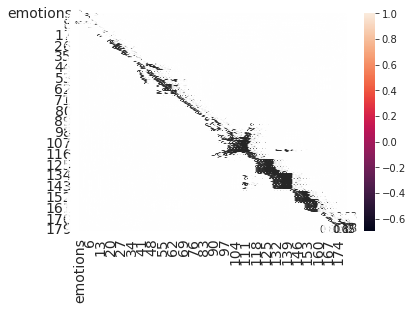

<Figure size 432x288 with 0 Axes>

In [58]:
temp = df

temp['emotions'] = temp['emotions'].astype('category').cat.codes
sns.heatmap(temp.corr(),annot = True,annot_kws = {"size":10})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.savefig('Emotions Heatmap.png', dpi=600)

##### 4.4. Data Splitting

###### 4.4.1. Importing Packages

In [59]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

###### 4.4.2. Splitting Function

In [60]:
def data_split(df):
    train_ratio = 0.75
    validation_ratio = 0.15
    test_ratio = 0.10

    new_df = df.copy()
    new_df = shuffle(new_df)

    X = new_df.iloc[:, 1:]
    print('Dimensions of X: ', X.shape)

    y = new_df.iloc[:, 0]
    print('Dimensions of y: ', y.shape)

    # 75% Training, 15% Validation, 10% Testing.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

    print('Dimensions of X_train, X_val, X_test: ', X_train.shape, X_val.shape, X_test.shape)
    print('Dimensions of y_train, y_val, y_test: ', y_train.shape, y_val.shape, y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test

###### 4.4.3. Spliting

In [79]:
print('Mel')
mel_X_train, mel_X_val, mel_X_test, mel_y_train, mel_y_val, mel_y_test = data_split(mel_data)
print('\nChroma')
chroma_X_train, chroma_X_val, chroma_X_test, chroma_y_train, chroma_y_val, chroma_y_test = data_split(chroma_data)
print('\nMFCC')
mfcc_X_train, mfcc_X_val, mfcc_X_test, mfcc_y_train, mfcc_y_val, mfcc_y_test = data_split(mfcc_data)
print('\nAll Features')
X_train, X_val, X_test, y_train, y_val, y_test = data_split(df)

Mel
Dimensions of X:  (3492, 128)
Dimensions of y:  (3492,)
Dimensions of X_train, X_val, X_test:  (2619, 128) (523, 128) (350, 128)
Dimensions of y_train, y_val, y_test:  (2619,) (523,) (350,)

Chroma
Dimensions of X:  (3492, 12)
Dimensions of y:  (3492,)
Dimensions of X_train, X_val, X_test:  (2619, 12) (523, 12) (350, 12)
Dimensions of y_train, y_val, y_test:  (2619,) (523,) (350,)

MFCC
Dimensions of X:  (3492, 40)
Dimensions of y:  (3492,)
Dimensions of X_train, X_val, X_test:  (2619, 40) (523, 40) (350, 40)
Dimensions of y_train, y_val, y_test:  (2619,) (523,) (350,)

All Features
Dimensions of X:  (3464, 180)
Dimensions of y:  (3464,)
Dimensions of X_train, X_val, X_test:  (2598, 180) (519, 180) (347, 180)
Dimensions of y_train, y_val, y_test:  (2598,) (519,) (347,)


##### 4.5. Feature Scaling

This is a method used to normalize the range of independent variables or features of data. We use the Normalization method in this notebook

###### 4.5.1 Importing Packages

In [80]:
import tensorflow as tf

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

###### 4.5.2 Defining Feature Scaling Functions

In [81]:
def norm(train, val, test):
    scaler = MinMaxScaler()
    train_norm = scaler.fit_transform(train)
    val_norm = scaler.fit_transform(val)
    test_norm = scaler.fit_transform(test)
    print('Dimensions of norm: ', train_norm.shape, val_norm.shape, test_norm.shape)
    return train_norm, val_norm, test_norm

def to_array(train, val, test):
    train = np.array(train)
    val = np.array(val)
    test = np.array(test)

    return train, val, test

def dim_expand(train, val, test):
    train_exp = np.expand_dims(train, axis=2)
    val_exp = np.expand_dims(val, axis=2)
    test_exp = np.expand_dims(test, axis=2)

    print('Dimensions of Expansion data: ', train_exp.shape, val_exp.shape, test_exp.shape)

    return train_exp, val_exp, test_exp

def encode(train, val, test):
    le = LabelEncoder()
    train_encode = keras.utils.to_categorical(le.fit_transform(train))
    val_encode = keras.utils.to_categorical(le.fit_transform(val))
    test_encode = keras.utils.to_categorical(le.fit_transform(test))

    print('Dimensions of Encoded data: ', train_encode.shape, val_encode.shape, test_encode.shape)

    return train_encode, val_encode, test_encode

def to_tensor(train, val, test):
    train_tensor = tf.convert_to_tensor(train)
    val_tensor = tf.convert_to_tensor(val)
    test_tensor = tf.convert_to_tensor(test)

    print('Dimensions of Tensor data: ', train_tensor.shape, val_tensor.shape, test_tensor.shape)

    return train_tensor, val_tensor, test_tensor

In [82]:
print('Mel')
#Converting the mel_X data to an Array
mel_X_train, mel_X_val, mel_X_test = to_array(mel_X_train, mel_X_val, mel_X_test)
mel_y_train, mel_y_val, mel_y_test = to_array(mel_y_train, mel_y_val, mel_y_test)
#Normalizing the mel_X data
mel_X_train, mel_X_val, mel_X_test = norm(mel_X_train, mel_X_val, mel_X_test)
#Encoding the mel_y data
en_mel_y_train, en_mel_y_val, en_mel_y_test= encode(mel_y_train, mel_y_val, mel_y_test)
#Expanding the mel_X data Dimensions
mel_X_train, mel_X_val, mel_X_test = dim_expand(mel_X_train, mel_X_val, mel_X_test)
#Converting the mel_X data to Tensors
tf_mel_X_train, tf_mel_X_val, tf_mel_X_test= to_tensor(mel_X_train, mel_X_val, mel_X_test)
tf_mel_y_train, tf_mel_y_val, tf_mel_y_test= to_tensor(en_mel_y_train, en_mel_y_val, en_mel_y_test)


print('\nChroma')
#Converting the chroma_X data to an Array
chroma_X_train, chroma_X_val, chroma_X_test = to_array(chroma_X_train, chroma_X_val, chroma_X_test)
chroma_y_train, chroma_y_val, chroma_y_test = to_array(chroma_y_train, chroma_y_val, chroma_y_test)
#Normalizing the chroma_X data
chroma_X_train, chroma_X_val, chroma_X_test = norm(chroma_X_train, chroma_X_val, chroma_X_test)
#Encoding the chroma_y data
en_chroma_y_train, en_chroma_y_val, en_chroma_y_test= encode(chroma_y_train, chroma_y_val, chroma_y_test)
#Expanding the chroma_X data Dimensions
chroma_X_train, chroma_X_val, chroma_X_test = dim_expand(chroma_X_train, chroma_X_val, chroma_X_test)
#Converting the chroma_X data to Tensors
tf_chroma_X_train, tf_chroma_X_val, tf_chroma_X_test= to_tensor(chroma_X_train, chroma_X_val, chroma_X_test)
tf_chroma_y_train, tf_chroma_y_val, tf_chroma_y_test= to_tensor(en_chroma_y_train, en_chroma_y_val, en_chroma_y_test)

print('\nMFCC')
#Converting the mfcc_X data to an Array
mfcc_X_train, mfcc_X_val, mfcc_X_test = to_array(mfcc_X_train, mfcc_X_val, mfcc_X_test)
mfcc_y_train, mfcc_y_val, mfcc_y_test = to_array(mfcc_y_train, mfcc_y_val, mfcc_y_test)
#Normalizing the mfcc_X data
mfcc_X_train, mfcc_X_val, mfcc_X_test = norm(mfcc_X_train, mfcc_X_val, mfcc_X_test)
#Encoding the mfcc_y data
en_mfcc_y_train, en_mfcc_y_val, en_mfcc_y_test= encode(mfcc_y_train, mfcc_y_val, mfcc_y_test)
#Expanding the mfcc_X data Dimensions
mfcc_X_train, mfcc_X_val, mfcc_X_test = dim_expand(mfcc_X_train, mfcc_X_val, mfcc_X_test)
#Converting the mfcc_X data to Tensors
tf_mfcc_X_train, tf_mfcc_X_val, tf_mfcc_X_test= to_tensor(mfcc_X_train, mfcc_X_val, mfcc_X_test)
tf_mfcc_y_train, tf_mfcc_y_val, tf_mfcc_y_test= to_tensor(en_mfcc_y_train, en_mfcc_y_val, en_mfcc_y_test)

print('\nAll Features')
#Converting the X data to an Array
X_train, X_val, X_test = to_array(X_train, X_val, X_test)
y_train, y_val, y_test = to_array(y_train, y_val, y_test)
#Normalizing the X data
X_train, X_val, X_test = norm(X_train, X_val, X_test)
#Encoding the y data
en_y_train, en_y_val, en_y_test= encode(y_train, y_val, y_test)
#Expanding the X data Dimensions
X_train, X_val, X_test = dim_expand(X_train, X_val, X_test)
#Converting the X data to Tensors
tf_X_train, tf_X_val, tf_X_test= to_tensor(X_train, X_val, X_test)
tf_y_train, tf_y_val, tf_y_test= to_tensor(en_y_train, en_y_val, en_y_test)

Mel
Dimensions of norm:  (2619, 128) (523, 128) (350, 128)
Dimensions of Encoded data:  (2619, 8) (523, 8) (350, 8)
Dimensions of Expansion data:  (2619, 128, 1) (523, 128, 1) (350, 128, 1)
Dimensions of Tensor data:  (2619, 128, 1) (523, 128, 1) (350, 128, 1)
Dimensions of Tensor data:  (2619, 8) (523, 8) (350, 8)

Chroma
Dimensions of norm:  (2619, 12) (523, 12) (350, 12)
Dimensions of Encoded data:  (2619, 8) (523, 8) (350, 8)
Dimensions of Expansion data:  (2619, 12, 1) (523, 12, 1) (350, 12, 1)
Dimensions of Tensor data:  (2619, 12, 1) (523, 12, 1) (350, 12, 1)
Dimensions of Tensor data:  (2619, 8) (523, 8) (350, 8)

MFCC
Dimensions of norm:  (2619, 40) (523, 40) (350, 40)
Dimensions of Encoded data:  (2619, 8) (523, 8) (350, 8)
Dimensions of Expansion data:  (2619, 40, 1) (523, 40, 1) (350, 40, 1)
Dimensions of Tensor data:  (2619, 40, 1) (523, 40, 1) (350, 40, 1)
Dimensions of Tensor data:  (2619, 8) (523, 8) (350, 8)

All Features
Dimensions of norm:  (2598, 180) (519, 180) (34

##### Model Training Plot

In [83]:
def plot_train(hist):
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    cost = hist['loss']
    val_cost = hist['val_loss']
    iters = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(25,10))
    
    #Plot Accuracy
    axes[0].plot(iters, acc, 'b-', label='Training Accuracy')
    axes[0].plot(iters, val_acc, 'g--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='best')

    #Plot Cost
    axes[1].plot(iters, cost, 'b-', label='Training Cost')
    axes[1].plot(iters, val_cost, 'g--', label='Validation Cost')
    axes[1].set_title('Training and Validation Cost')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Cost')
    axes[1].legend(loc='best')

    return plt

### <b>Baseline Model</b>

##### Library Import

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import *

#tensorflow functions
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Convolution1D, MaxPooling1D, BatchNormalization, Dropout, AveragePooling1D

#keras Tuner functions
import keras_tuner as kt
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch, Hyperband

In [85]:
# constants
class_labels = {0 : 'neutral',
            1 : 'calm',
            2 : 'happy',
            3 : 'sad',
            4 : 'angry',
            5 : 'fear',
            6 : 'disgust',
            7 : 'surprise'}

classes = list(class_labels.values())

In [86]:
def cnn_baseline(X_train, X_val, y_train, y_val, data_shape, no_of_classes=8, iters = 20):
    model= Sequential()


    #convolution layer
    model.add(Conv1D(32, 3, padding='same', activation='relu', input_shape = data_shape))
    model.add(Conv1D(32, 3, padding='same', activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    #pooling layer
    model.add(Conv1D(64, 3, padding='same', activation='relu'))
    #model.add(BatchNormalization())
    model.add(Conv1D(64, 3, padding='same'))
    #model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))


    #fully connected layer
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    #output layer
    model.add(Dense(no_of_classes, activation='softmax'))

    #Model Compilation
    model.compile(optimizer = keras.optimizers.Adam(lr=0.001, epsilon=1e-07, decay=0.0),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    #Baseline Model Architecture
    keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

    #Baseline Model Architecture Information
    print(model.summary())

    

    model_hist = model.fit(X_train, y_train, epochs=iters, validation_data = (X_val, y_val))

    return model_hist, model

In [96]:
#mel_model
mel_shape = mel_X_train.shape[1:]

mel_hist, mel_model = cnn_baseline(tf_mel_X_train, tf_mel_X_val, tf_mel_y_train, tf_mel_y_val, mel_shape)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 128, 32)           128       
                                                                 
 conv1d_21 (Conv1D)          (None, 128, 32)           3104      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 64, 32)           0         
 g1D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 64, 32)           128       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 64, 32)            0         
                                                                 
 conv1d_22 (Conv1D)          (None, 64, 64)           

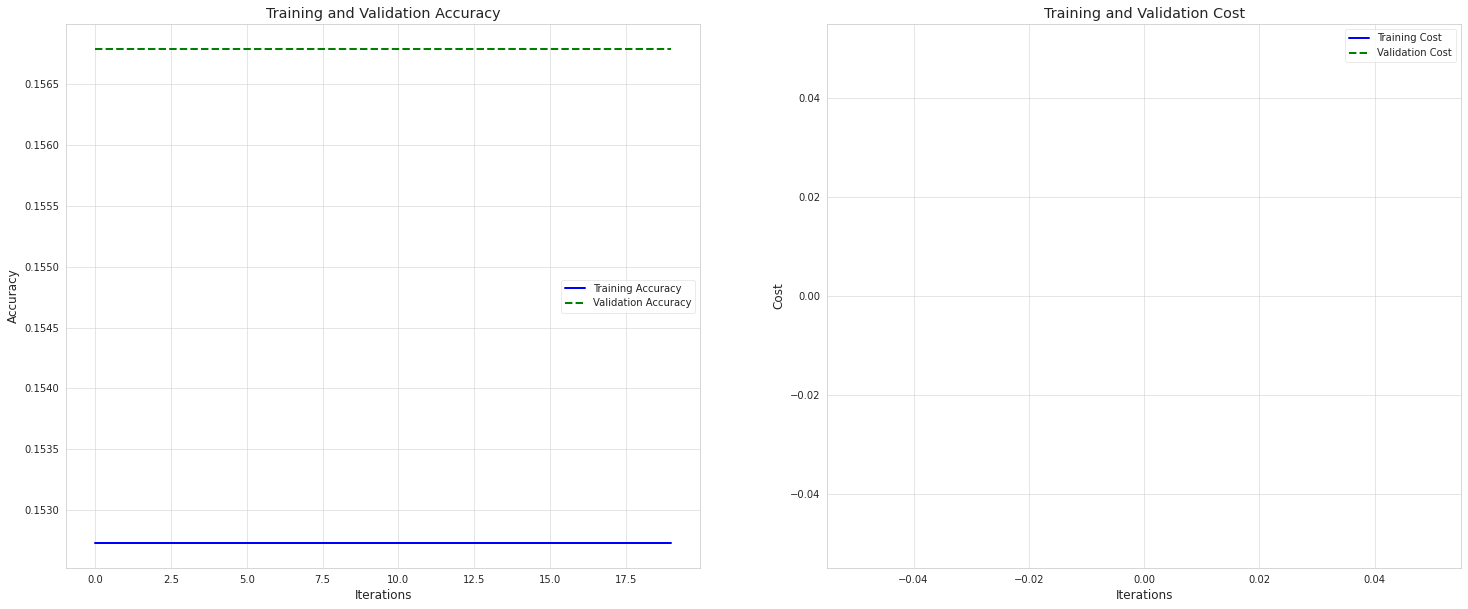

In [97]:
plt = plot_train(mel_hist.history)   
plt.savefig('mel_prediction_graph.png', dpi=600)    
plt.show()

In [98]:
#chroma_model
chroma_shape = chroma_X_train.shape[1:]

chroma_hist, chroma_model = cnn_baseline(tf_chroma_X_train, tf_chroma_X_val, tf_chroma_y_train, tf_chroma_y_val, chroma_shape)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 12, 32)            128       
                                                                 
 conv1d_25 (Conv1D)          (None, 12, 32)            3104      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 6, 32)            0         
 g1D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 6, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 6, 32)             0         
                                                                 
 conv1d_26 (Conv1D)          (None, 6, 64)            

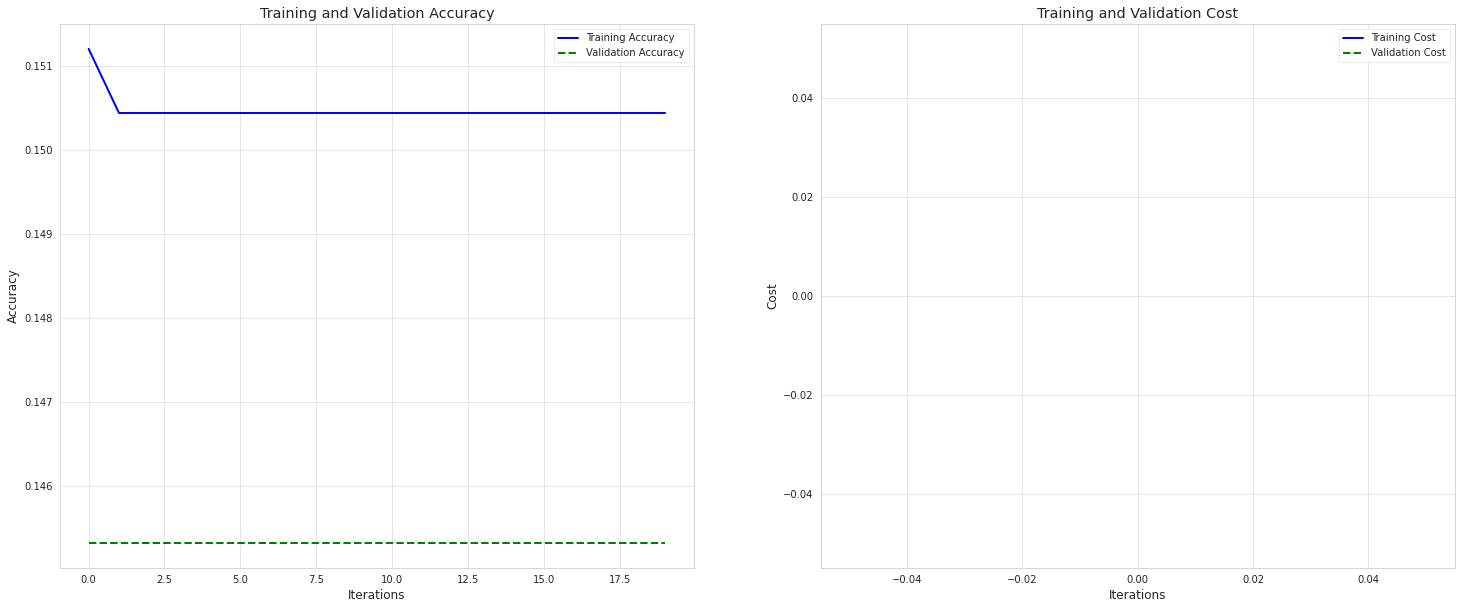

In [99]:
plt = plot_train(chroma_hist.history)   
plt.savefig('chroma_prediction_graph.png', dpi=600)    
plt.show()

In [100]:
#mfcc_model
mfcc_shape = mfcc_X_train.shape[1:]

mfcc_hist, mfcc_model = cnn_baseline(tf_mfcc_X_train, tf_mfcc_X_val, tf_mfcc_y_train, tf_mfcc_y_val, mfcc_shape)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 40, 32)            128       
                                                                 
 conv1d_29 (Conv1D)          (None, 40, 32)            3104      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 20, 32)           0         
 g1D)                                                            
                                                                 
 batch_normalization_21 (Bat  (None, 20, 32)           128       
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 20, 32)            0         
                                                                 
 conv1d_30 (Conv1D)          (None, 20, 64)           

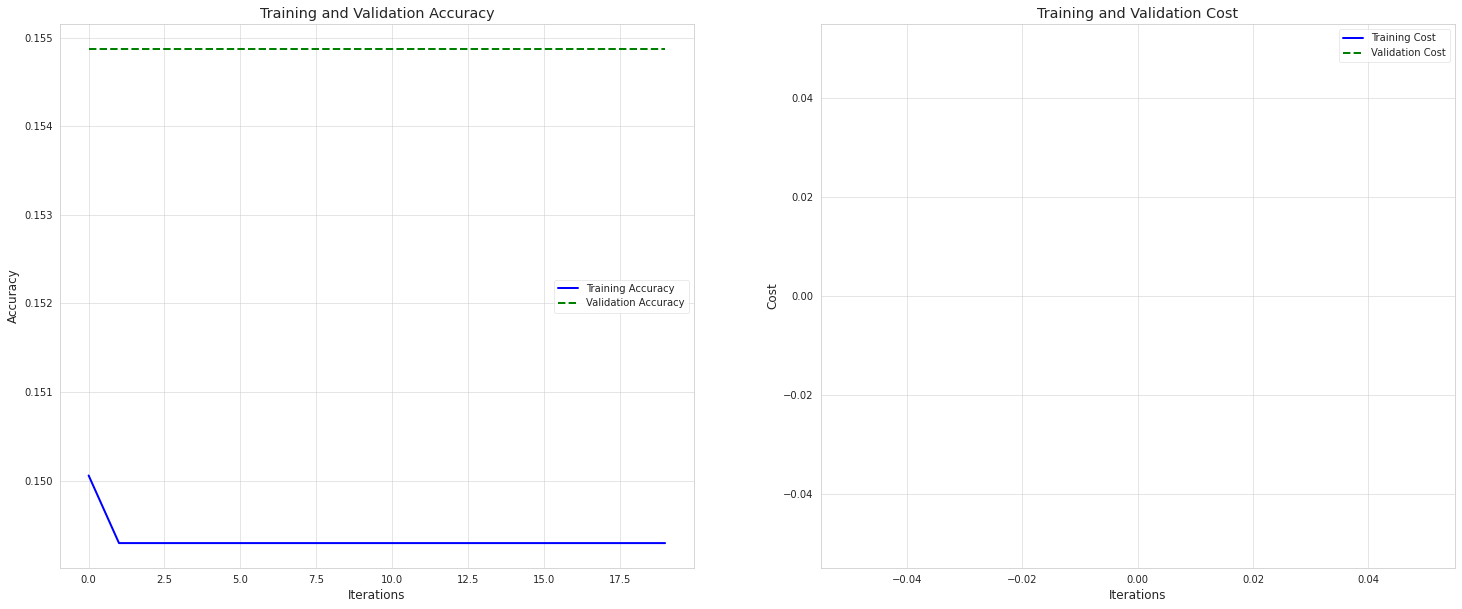

In [101]:
plt = plot_train(mfcc_hist.history)   
plt.savefig('mfcc_prediction_graph.png', dpi=400)    
plt.show()

In [102]:
#mfcc_model
df_shape = X_train.shape[1:]

df_hist, df_model = cnn_baseline(tf_X_train, tf_X_val, en_y_train, en_y_val, df_shape)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 180, 32)           128       
                                                                 
 conv1d_33 (Conv1D)          (None, 180, 32)           3104      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 90, 32)           0         
 g1D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 90, 32)           128       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 90, 32)            0         
                                                                 
 conv1d_34 (Conv1D)          (None, 90, 64)           

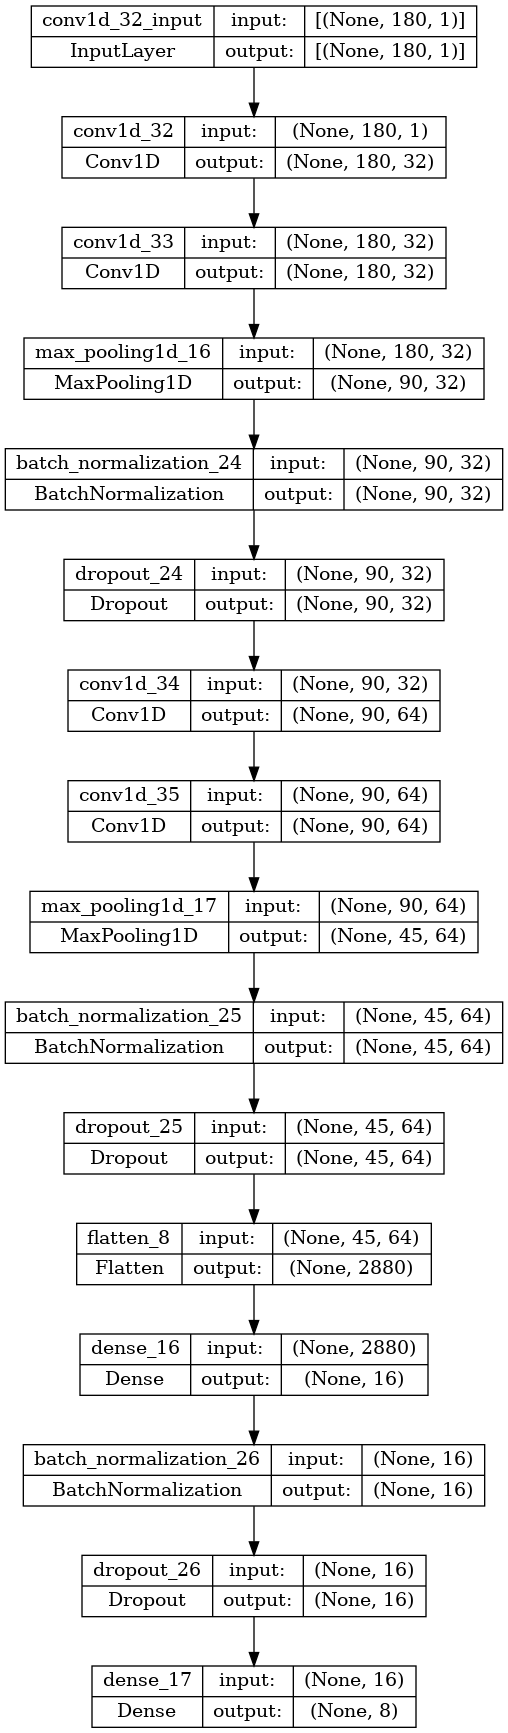

In [112]:
keras.utils.plot_model(df_model, to_file='Baseline_Model.png', show_shapes=True, show_layer_names=True)

##### Baseline Model Plot

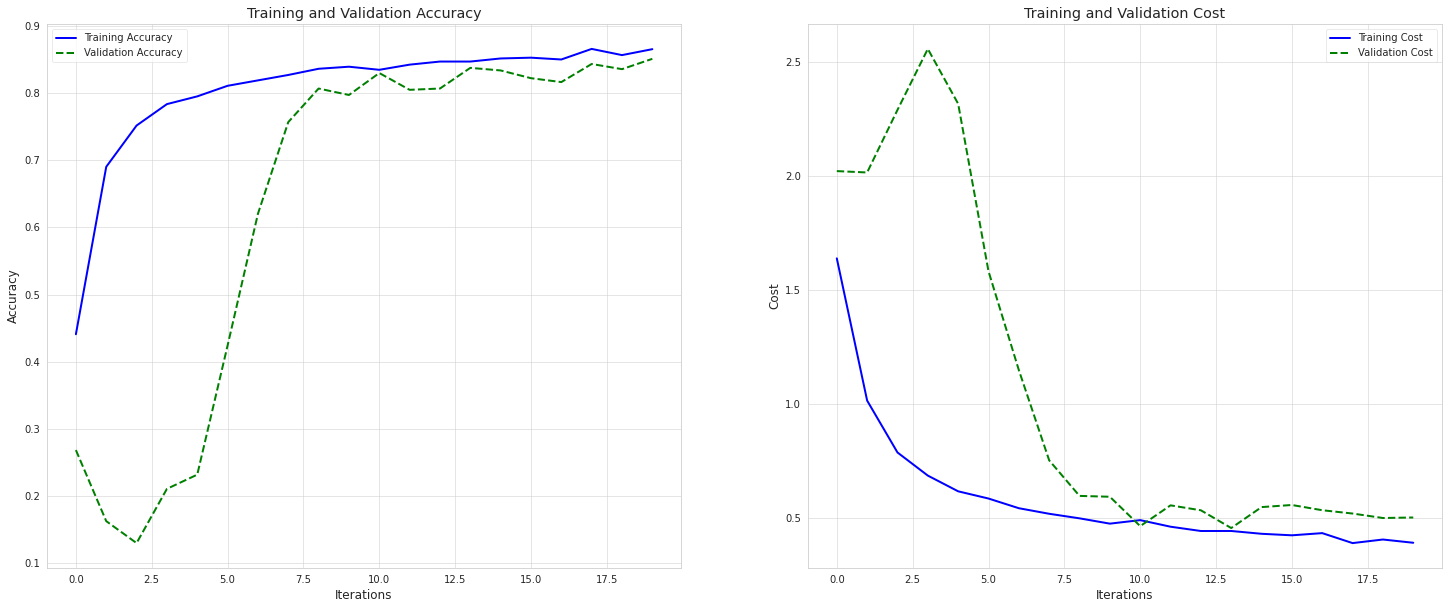

In [103]:
plt = plot_train(df_hist.history)   
plt.savefig('all_prediction_graph.png', dpi=600)    
plt.show()

##### Baseline Model Predictions

In [147]:
cls_y_val = np.argmax(en_y_val, axis=1)
cls_y_val = cls_y_val.reshape(en_y_val.shape[0],1)
predictions = df_model.predict(tf_X_val)
cls_y_pred = np.argmax(predictions, axis=1)
cls_y_pred = cls_y_pred.reshape(cls_y_pred.shape[0],1)

print(cls_y_pred.shape)
print(cls_y_val.shape)

17/17 [==============================] - 0s 4ms/step
(519, 1)
(519, 1)


##### Baseline Model Confusion Matrix

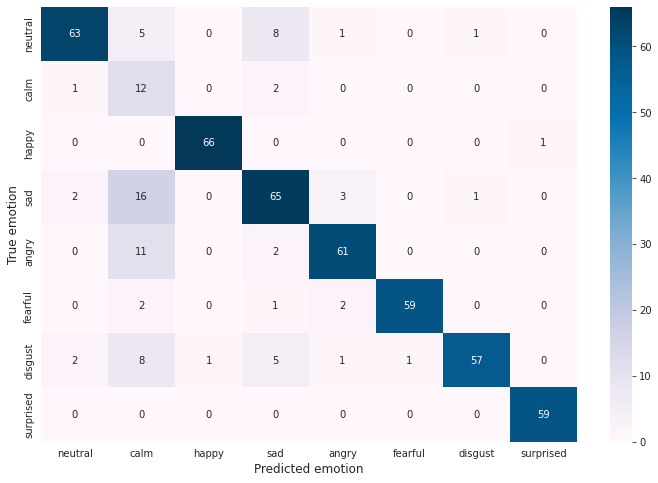

In [153]:
cm=confusion_matrix(cls_y_val, cls_y_pred)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')
plt.savefig('baseline confusion matrix.png', dpi=600) 
plt.show()

##### Baseline Model Classification Report

In [125]:
from sklearn.metrics import confusion_matrix, classification_report

In [149]:
print(classification_report(cls_y_val, cls_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86        78
           1       0.22      0.80      0.35        15
           2       0.99      0.99      0.99        67
           3       0.78      0.75      0.76        87
           4       0.90      0.82      0.86        74
           5       0.98      0.92      0.95        64
           6       0.97      0.76      0.85        75
           7       0.98      1.00      0.99        59

    accuracy                           0.85       519
   macro avg       0.84      0.86      0.83       519
weighted avg       0.90      0.85      0.87       519



##### Model Saving

In [105]:
path = os.getcwd()

model_name = 'Emotion_Prdiction_Model.h5'
save_dir = os.path.join(path, 'models')

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
model.save(model_path)

##### Model Loading

In [106]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

##### Model Evaluation 

In [109]:
cost_eval, acc_eval = df_model.evaluate(tf_X_test, en_y_test)

print("Cost Evaluation", cost_eval)
print("Accuracy Evaluation", "{:.2%}" .format(acc_eval))

11/11 [==============================] - 0s 4ms/step - loss: 0.3518 - accuracy: 0.8761
Cost Evaluation 0.35184788703918457
Accuracy Evaluation 87.61%


### <b>Hyperparameter Tuning</b>

In [110]:
class Hyper_Emotion_Pred(HyperModel):
    
    def __init__(self, data_shape, no_of_classes=8):
        self.data_shape = data_shape
        self.no_of_classes = no_of_classes
        
        
    def build(self, hyper):

        model= Sequential()

        #convolution layer
        model.add(Conv1D(filters = hyper.Choice('Conv_Filters_1',values=[64, 128, 256], default=64), 
                         kernel_size = 5, 
                         input_shape = self.data_shape))
        model.add(Conv1D(filters = hyper.Choice('Conv_Filters_1',values=[64, 128, 256], default=64), 
                         kernel_size = 3, 
                         activation = hyper.Choice('Conv_Activation_1', values=['relu', 'sigmoid'], default='relu')))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate = hyper.Float('Dropout_Rate_1', min_value=0.0, max_value=0.5, default=0.25,step=0.05)))

        model.add(Conv1D(filters=hyper.Choice('Conv_Filters_1',values=[16, 32, 64],default=16),activation='relu',kernel_size=3, input_shape=self.data_shape))
        model.add(Conv1D(filters=hyper.Choice('Conv_Filters_1',values=[16, 32, 64],default=16), activation=hyper.Choice('Conv_Activation_2',values=['relu', 'sigmoid'],default='relu'),kernel_size=3))
        model.add(Dropout(rate=hyper.Float('Dropout_Rate_1',min_value=0.0,max_value=0.5,default=0.25,step=0.05)))


        #pooling layer
        model.add(MaxPooling1D(pool_size=(2)))
        model.add(BatchNormalization())
        model.add(Conv1D(64, 3, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=(2)))
        model.add(BatchNormalization())
        model.add(Conv1D(128, 3, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=(2)))
        model.add(BatchNormalization())

        #fully connected layer
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        #output layer
        model.add(Dense(self.no_of_classes, activation='softmax'))

        model.compile(optimizer=keras.optimizers.Adam(hyper.Float('Adam_Optim_LR',
                       min_value=1e-4,
                       max_value=1e-2,
                       sampling='LOG',
                       default=1e-3)),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
        
        print("model built") #just to check
        return model


In [111]:
hyper_model = Hyper_Emotion_Pred(df_shape)

##### SearchSpace Parameters

In [122]:
seed = 2
no_iters = 20
trials = 2
no_each_trial = 20


hyper_tuner = RandomSearch(hyper_model, 
                           objective = 'val_accuracy', 
                           seed = seed, 
                           max_trials = no_each_trial, 
                           #execution_per_trial = trials,
                           project_name = 'HyperTuned_Emotion_Prediction')

model built


##### Hyperparameter Model Summary

In [123]:
hyper_tuner.search_space_summary()

Search space summary
Default search space size: 5
Conv_Filters_1 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
Conv_Activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
Dropout_Rate_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
Conv_Activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
Adam_Optim_LR (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


##### Best HyperParameters

In [124]:
hyper_tuner.search(x = tf_X_train, y = en_y_train, epochs = no_iters, validation_data = (tf_X_val, en_y_val))

Trial 20 Complete [00h 00m 43s]
val_accuracy: 0.8188824653625488

Best val_accuracy So Far: 0.8477842211723328
Total elapsed time: 00h 29m 21s
INFO:tensorflow:Oracle triggered exit


##### Hyper Model Architecture

In [118]:
hyper_tuner.results_summary()

Results summary
Results in ./HyperTuned_Emotion_Prediction
Showing 10 best trials
Trial summary
Hyperparameters:
Conv_Filters_1: 128
Conv_Activation_1: sigmoid
Dropout_Rate_1: 0.05
Conv_Activation_2: relu
Adam_Optim_LR: 0.0005285006792644589
Score: 0.8978805541992188
Trial summary
Hyperparameters:
Conv_Filters_1: 128
Conv_Activation_1: sigmoid
Dropout_Rate_1: 0.05
Conv_Activation_2: sigmoid
Adam_Optim_LR: 0.0003069273045576997
Score: 0.8978805541992188
Trial summary
Hyperparameters:
Conv_Filters_1: 128
Conv_Activation_1: relu
Dropout_Rate_1: 0.05
Conv_Activation_2: sigmoid
Adam_Optim_LR: 0.0010277342442932575
Score: 0.8959537744522095
Trial summary
Hyperparameters:
Conv_Filters_1: 128
Conv_Activation_1: relu
Dropout_Rate_1: 0.25
Conv_Activation_2: relu
Adam_Optim_LR: 0.0008030805486457598
Score: 0.8882466554641724
Trial summary
Hyperparameters:
Conv_Filters_1: 256
Conv_Activation_1: sigmoid
Dropout_Rate_1: 0.1
Conv_Activation_2: sigmoid
Adam_Optim_LR: 0.0005781511315714686
Score: 0.886

##### Best Model

model built


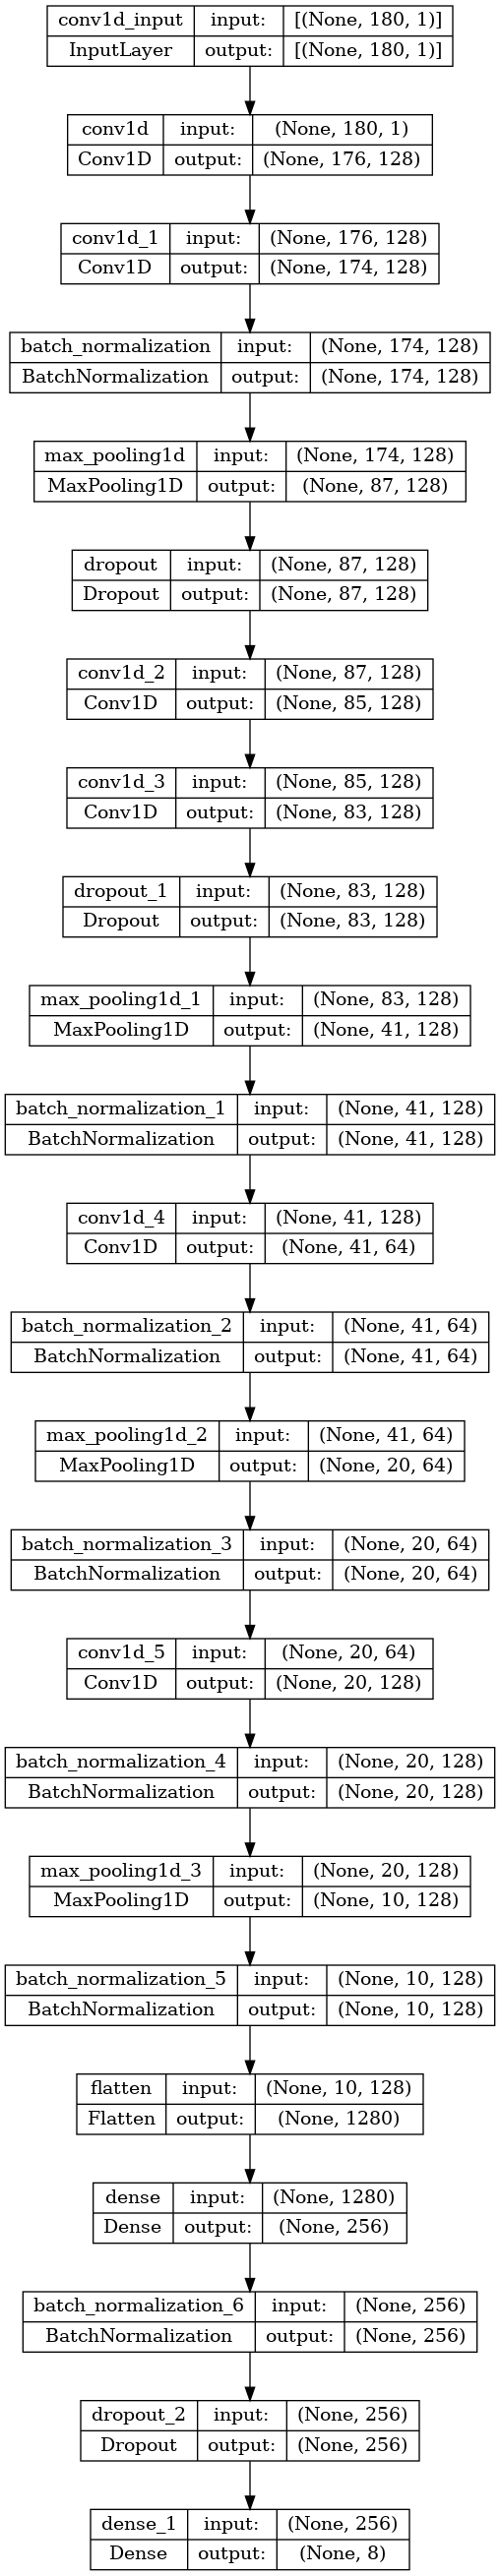

In [119]:
optimal_model = hyper_tuner.get_best_models()[0]

keras.utils.plot_model(optimal_model, to_file='HyperTuned_Model.png', show_shapes=True, show_layer_names=True)

##### HyperParameter Model Evaluation

In [150]:
cost_eval, acc_eval = optimal_model.evaluate(tf_X_test, en_y_test)

print("Cost Evaluation", cost_eval)
print("Accuracy Evaluation", "{:.2%}" .format(acc_eval))

11/11 [==============================] - 0s 4ms/step - loss: 0.3617 - accuracy: 0.8934
Cost Evaluation 0.3616917133331299
Accuracy Evaluation 89.34%


In [151]:
iters_train = 20
batch_size = 256

optimal_model_hist = optimal_model.fit(tf_X_train, en_y_train, epochs=iters_train, validation_data = (tf_X_val, en_y_val),  batch_size = batch_size)


val_acc = optimal_model_hist.history['val_accuracy']
optimal_iters = val_acc.index(max(val_acc)) + 1
print('Optimal No Iteration: %d' % (optimal_iters))

Epoch 1/20
11/11 [==============================] - 1s 85ms/step - loss: 0.3585 - accuracy: 0.8741 - val_loss: 0.4517 - val_accuracy: 0.8401
Epoch 2/20
11/11 [==============================] - 1s 78ms/step - loss: 0.3568 - accuracy: 0.8737 - val_loss: 0.4442 - val_accuracy: 0.8343
Epoch 3/20
11/11 [==============================] - 1s 88ms/step - loss: 0.3519 - accuracy: 0.8734 - val_loss: 0.4400 - val_accuracy: 0.8304
Epoch 4/20
11/11 [==============================] - 1s 70ms/step - loss: 0.3492 - accuracy: 0.8772 - val_loss: 0.4497 - val_accuracy: 0.8324
Epoch 5/20
11/11 [==============================] - 1s 76ms/step - loss: 0.3427 - accuracy: 0.8741 - val_loss: 0.4587 - val_accuracy: 0.8420
Epoch 6/20
11/11 [==============================] - 1s 72ms/step - loss: 0.3412 - accuracy: 0.8799 - val_loss: 0.4466 - val_accuracy: 0.8439
Epoch 7/20
11/11 [==============================] - 1s 72ms/step - loss: 0.3345 - accuracy: 0.8784 - val_loss: 0.4471 - val_accuracy: 0.8439
Epoch 8/20
11

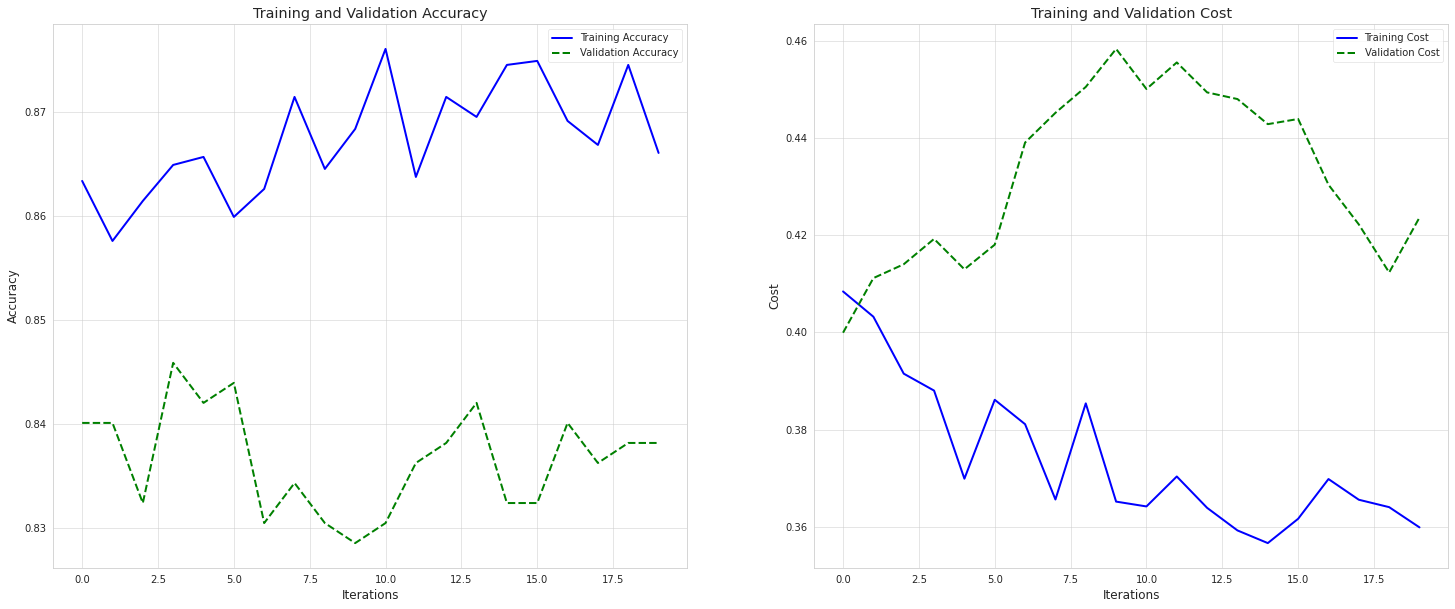

In [136]:
plt = plot_train(optimal_model_hist.history)   
plt.savefig('optimal_emotion_prediction_graph.png', dpi=600)    
plt.show()

In [137]:
cost_eval, acc_eval = optimal_model.evaluate(tf_X_test, en_y_test)

print("Cost Evaluation", cost_eval)
print("Accuracy Evaluation", "{:.2%}" .format(acc_eval))



11/11 [==============================] - 0s 4ms/step - loss: 0.3617 - accuracy: 0.8934
Cost Evaluation 0.3616917133331299
Accuracy Evaluation 89.34%


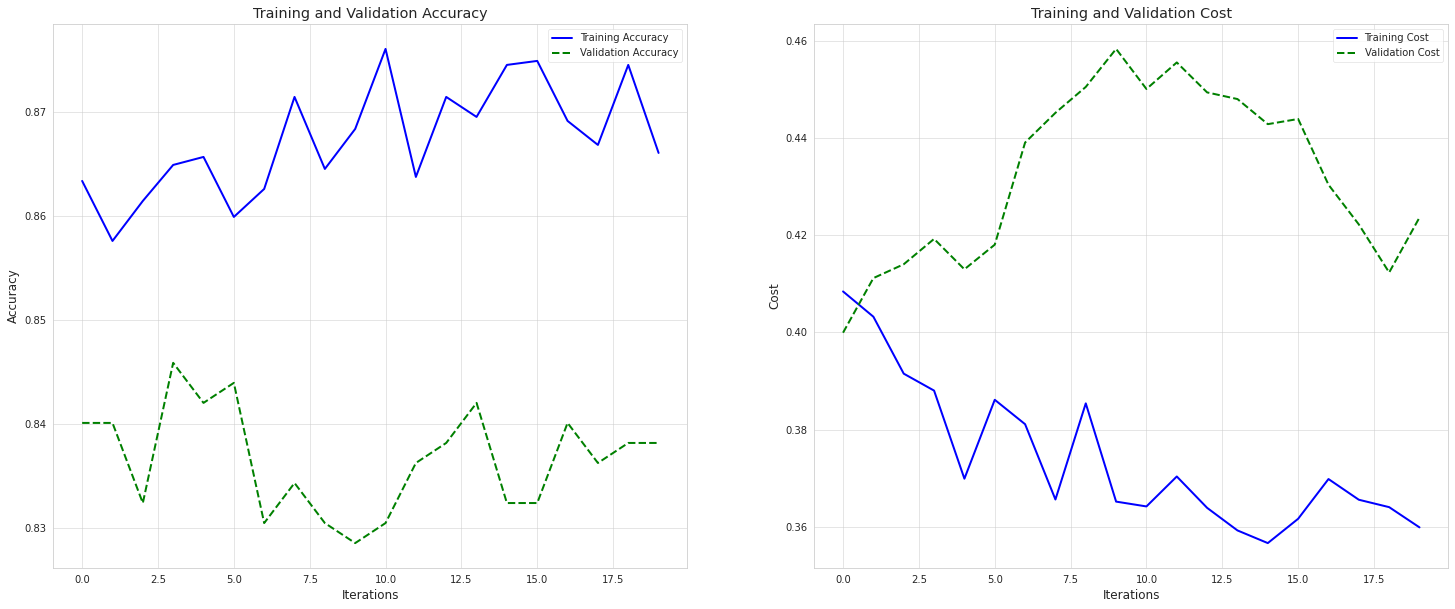

In [139]:
plt = plot_train(optimal_model_hist.history)   
plt.savefig('emotion_prediction_graph.png', dpi=600)    
plt.show()

#### 4. <b>Classification Reports and Confusion Matrix</b>

##### Prediction Accuracy

In [143]:
opt_cls_y_val = np.argmax(en_y_val, axis=1)
opt_cls_y_val = opt_cls_y_val.reshape(en_y_val.shape[0],1)
predictions = optimal_model.predict(tf_X_val)
opt_cls_y_pred = np.argmax(predictions, axis=1)
opt_cls_y_pred = opt_cls_y_pred.reshape(opt_cls_y_pred.shape[0],1)

print(opt_cls_y_pred.shape)
print(opt_cls_y_val.shape)

17/17 [==============================] - 0s 4ms/step
(519, 1)
(519, 1)


##### HyperTuned Confusion Matrix Heat Map

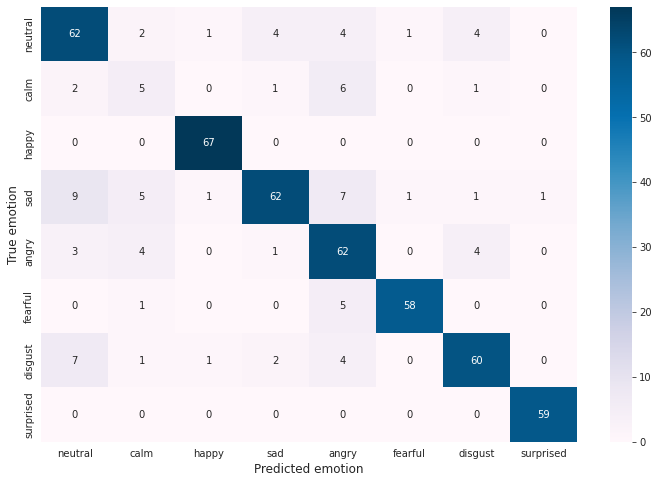

In [144]:
cm= confusion_matrix(opt_cls_y_val, opt_cls_y_pred)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')
plt.show()

##### HyperTuned Model Classification Report

In [145]:
print(classification_report(opt_cls_y_val, opt_cls_y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77        78
           1       0.28      0.33      0.30        15
           2       0.96      1.00      0.98        67
           3       0.89      0.71      0.79        87
           4       0.70      0.84      0.77        74
           5       0.97      0.91      0.94        64
           6       0.86      0.80      0.83        75
           7       0.98      1.00      0.99        59

    accuracy                           0.84       519
   macro avg       0.80      0.80      0.80       519
weighted avg       0.85      0.84      0.84       519

